In [138]:
%matplotlib inline
%config Completer.use_jedi = False

import numpy as np
import math
import random
import datetime
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import pprint
from pandas.plotting import register_matplotlib_converters
from collections import deque
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
from tqdm import tqdm

from qiskit.finance.data_providers import *
from qiskit.finance import QiskitFinanceError

from docplex.mp.model import Model

from qiskit.aqua.components.optimizers import COBYLA, SLSQP
register_matplotlib_converters()

# imported before setting global log level, since optim_wrapper sets log level
import grovers_search as grovers
import optim_wrapper as optimization

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
# setup aqua logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.ERROR)  # choose INFO, DEBUG to see the log

### Defining functions

In [2]:
def aggregator(algorithm, dict_details):
    if algorithm == 'grovers':
        result = grovers.grovers_search(dict_details)
    if algorithm == 'optimizer':
        result = optimization.optimize_portfolio(dict_details)
    return result

In [265]:
def dates_gen(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

#test
s=datetime.datetime(2017, 1, 1)
e=datetime.datetime(2017, 6, 30)
d=relativedelta(months=1)

for date in dates_gen(s, e, d):
    print(date)

2017-01-01 00:00:00
2017-02-01 00:00:00
2017-03-01 00:00:00
2017-04-01 00:00:00
2017-05-01 00:00:00
2017-06-01 00:00:00


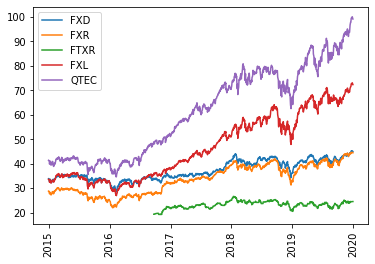

In [87]:
def is_market_data_complete(market_data):
    if isinstance(market_data, list):
        masks = [pd.notna(md) for md in market_data]
        return pd.concat(masks, axis='columns').all(axis=None)
    else:
        return pd.notna(market_data).all()

# test   
try:
    data_nan = YahooDataProvider(
                 tickers = ['FXD', 'FXR', 'FTXR', 'FXL', 'QTEC'], # IFV ETF 
                 start=datetime.datetime(2015, 1, 1),
                 end=datetime.datetime(2019, 12, 31))
    data_nan.run()
    for (cnt, s) in enumerate(data_nan._tickers):
        plt.plot(data_nan._data[cnt], label=s)
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()
except QiskitFinanceError as ex:
    data_nan = None
    print(ex)
assert not is_market_data_complete(data_nan._data)


data_nan_single = data_nan._data[2]  #the only incomplete time series is 'FTXR'
assert not is_market_data_complete(data_nan_single)

    
data_nonan = YahooDataProvider(
             tickers = ['FXD', 'FXR', 'FTXR', 'FXL', 'QTEC'],
             start=datetime.datetime(2017, 1, 1),
             end=datetime.datetime(2019, 12, 31))
data_nonan.run()
assert is_market_data_complete(data_nonan._data)


data_nonan_single = data_nonan._data[0]
assert is_market_data_complete(data_nonan_single)

### Initializing inputs

In [266]:
solvers = ['vqe', 'classic']

n = 5            # number of assets
q = 0.5          # risk factor
budget = n // 2  # budget in # of stocks
penalty = 2*n    # scaling of penalty term

optim_dict = {
  #"docplex_mod": mdl,
  "quantum_instance": 'qasm_simulator',
  "shots": 1024,
  "print": False, 
  #"solver": solver_name, (to be added before calling aggregator)
  "optimizer": SLSQP,
  "maxiter":1000,
  "depth":1,
  "alpha":0.35,
  "penalty": 2*n
}

# FTSE MIB
symbols = ['MB.MI','STM.MI','IP.MI','PRY.MI','REC.MI',
           'TEN.MI','IG.MI', 'CPR.MI','AZM.MI','G.MI',
           'RACE.MI','BPE.MI','BAMI.MI','FBK.MI', 'SPM.MI',
           'ENI.MI','SRG.MI','ATL.MI','MONC.MI','TIT.MI',
           'LDO.MI','CNHI.MI','PST.MI','UNI.MI','TRN.MI',
           'BZU.MI', 'AMP.MI','BMED.MI','DIA.MI','PIRC.MI', 
           'A2A.MI', 'BGN.MI', 'ENEL.MI', 'EXO.MI', 'HER.MI', 
           'ISP.MI', 'INW.MI', 'NEXI.MI', 'STLA.MI', 'UCG.MI']
n_portfolios = 100

optim_start_date=datetime.datetime(2018, 7, 1)
optim_end_date=datetime.datetime(2019, 12, 31)
optim_step_delta=relativedelta(months=1)
past_delta=relativedelta(months=6)  #used to compute mu and sigma at each optimization step

### Building the portfolios

In [267]:
# retains only symbols with no missing data in the overall computation time window
start = optim_start_date-past_delta
end = optim_end_date
data_all_symbols = YahooDataProvider(tickers=symbols, start=start, end=end)
data_all_symbols.run()

complete_symbols = set()
for symbol, market_data in zip(data_all_symbols._tickers, data_all_symbols._data):
    if is_market_data_complete(market_data):
        complete_symbols.add(symbol)
    else:
        print(f"{symbol} data incomplete over the selected time period")

# build n_portfolios random portfolios of n assets selected from the ones whose data is complete
portfolios = set()
while len(portfolios)<n_portfolios:
    #sort for uniques in set (variation -> combination)
    portfolio = tuple(sorted(random.sample(complete_symbols, n))) 
    portfolios.add(portfolio)
portfolios = list(portfolios)

NEXI.MI data incomplete over the selected time period


### Running the optimization

In [268]:
optim_dates = list(dates_gen(optim_start_date, optim_end_date, optim_step_delta)) #cast to list just for using tqdm

granular_results = {s : {p : {} for p in portfolios} for s in solvers}

for i, portfolio in enumerate(portfolios):
    print(f"Running on portfolio {i+1} of {len(portfolios)}: {portfolio}")

    for optim_date in tqdm(optim_dates):
        computation_start = optim_date-past_delta
        computation_end = optim_date

        # loads market data and compute mu and sigma
        data = YahooDataProvider(
                     tickers=list(portfolio), 
                     start=computation_start,
                     end=computation_end)
        data.run()
        mu = data.get_period_return_mean_vector()
        sigma = data.get_period_return_covariance_matrix()

        # create docplex model
        mdl = Model('portfolio_optimization')
        x = mdl.binary_var_list('x{}'.format(i) for i in range(n))
        objective = mdl.sum([mu[i]*x[i] for i in range(n)])
        objective -= q * mdl.sum([sigma[i,j]*x[i]*x[j] for i in range(n) for j in range(n)])
        mdl.maximize(objective)
        mdl.add_constraint(mdl.sum(x[i] for i in range(n)) == budget)

        # performs portfolio optimization using different optmizers
        for solver in solvers:
            optim_dict['docplex_mod'] = mdl
            optim_dict['solver'] = solver
            results = aggregator('optimizer', optim_dict)

            comp_time = results['computational_time']
            res = results['result']
            ret = sum([mu[i]*res.x[i] for i in range(n)])
            vol = q * sum([sigma[i,j]*res.x[i]*res.x[j] for i in range(n) for j in range(n)])
            objective_value = ret-vol 
            assert math.isclose(objective_value, res.fval, abs_tol=1e-10)    
            granular_results[solver][portfolio][optim_date] = {'objective_function_value': objective_value, 
                                                              'return': ret,
                                                              'volatility': vol, 
                                                              'computational_time': comp_time}

            #print(computation_start, computation_end)
            #print(f"solver: {s}, optim date: {optim_date}, success: {res.status}")
            #print(f"objective function value: {objective_value}, return term: {ret}, volatility term: {vol}, computation time {comp_time}")
            #print()

  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 1 of 100: ('ATL.MI', 'CPR.MI', 'FBK.MI', 'LDO.MI', 'PST.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 2 of 100: ('CNHI.MI', 'G.MI', 'PIRC.MI', 'PST.MI', 'TRN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 3 of 100: ('AZM.MI', 'BZU.MI', 'SRG.MI', 'STLA.MI', 'TIT.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 4 of 100: ('G.MI', 'PIRC.MI', 'PST.MI', 'REC.MI', 'STLA.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 5 of 100: ('BPE.MI', 'CNHI.MI', 'HER.MI', 'MONC.MI', 'PIRC.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 6 of 100: ('AZM.MI', 'BAMI.MI', 'BZU.MI', 'ENEL.MI', 'STLA.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 7 of 100: ('AZM.MI', 'BMED.MI', 'EXO.MI', 'FBK.MI', 'MONC.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 8 of 100: ('ATL.MI', 'BGN.MI', 'BMED.MI', 'LDO.MI', 'MONC.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 9 of 100: ('BAMI.MI', 'PIRC.MI', 'RACE.MI', 'SPM.MI', 'TIT.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 10 of 100: ('CPR.MI', 'PST.MI', 'RACE.MI', 'SPM.MI', 'TIT.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 11 of 100: ('A2A.MI', 'ENEL.MI', 'ENI.MI', 'IG.MI', 'UCG.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 12 of 100: ('AMP.MI', 'EXO.MI', 'IP.MI', 'ISP.MI', 'LDO.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 13 of 100: ('BZU.MI', 'FBK.MI', 'IG.MI', 'ISP.MI', 'PRY.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 14 of 100: ('FBK.MI', 'PRY.MI', 'PST.MI', 'TIT.MI', 'UNI.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 15 of 100: ('EXO.MI', 'HER.MI', 'PIRC.MI', 'RACE.MI', 'SRG.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 16 of 100: ('BAMI.MI', 'G.MI', 'INW.MI', 'IP.MI', 'SRG.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 17 of 100: ('AMP.MI', 'AZM.MI', 'IP.MI', 'MB.MI', 'RACE.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 18 of 100: ('A2A.MI', 'AMP.MI', 'ATL.MI', 'MONC.MI', 'TEN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 19 of 100: ('ATL.MI', 'CNHI.MI', 'LDO.MI', 'PST.MI', 'SPM.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 20 of 100: ('HER.MI', 'MB.MI', 'REC.MI', 'STM.MI', 'TIT.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 21 of 100: ('A2A.MI', 'AMP.MI', 'BGN.MI', 'ENI.MI', 'MONC.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 22 of 100: ('ATL.MI', 'AZM.MI', 'G.MI', 'LDO.MI', 'MONC.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 23 of 100: ('AMP.MI', 'BZU.MI', 'IP.MI', 'PIRC.MI', 'STM.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 24 of 100: ('BZU.MI', 'CPR.MI', 'ENEL.MI', 'SPM.MI', 'TRN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 25 of 100: ('A2A.MI', 'ENEL.MI', 'LDO.MI', 'SPM.MI', 'STM.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 26 of 100: ('CNHI.MI', 'ENEL.MI', 'FBK.MI', 'LDO.MI', 'REC.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 27 of 100: ('BAMI.MI', 'ENI.MI', 'EXO.MI', 'INW.MI', 'ISP.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 28 of 100: ('BPE.MI', 'BZU.MI', 'INW.MI', 'TEN.MI', 'UCG.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 29 of 100: ('BZU.MI', 'FBK.MI', 'G.MI', 'LDO.MI', 'RACE.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 30 of 100: ('ATL.MI', 'CPR.MI', 'ENI.MI', 'FBK.MI', 'STM.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 31 of 100: ('ATL.MI', 'CNHI.MI', 'ENI.MI', 'PIRC.MI', 'PST.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 32 of 100: ('INW.MI', 'LDO.MI', 'PST.MI', 'TIT.MI', 'TRN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 33 of 100: ('BMED.MI', 'DIA.MI', 'PRY.MI', 'STM.MI', 'UCG.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 34 of 100: ('AMP.MI', 'BZU.MI', 'CNHI.MI', 'ISP.MI', 'MONC.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 35 of 100: ('AZM.MI', 'BGN.MI', 'PRY.MI', 'SPM.MI', 'UNI.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 36 of 100: ('BGN.MI', 'ENEL.MI', 'HER.MI', 'PST.MI', 'TIT.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 37 of 100: ('CNHI.MI', 'FBK.MI', 'INW.MI', 'MONC.MI', 'PIRC.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 38 of 100: ('PST.MI', 'SRG.MI', 'TRN.MI', 'UCG.MI', 'UNI.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 39 of 100: ('AMP.MI', 'BPE.MI', 'LDO.MI', 'PRY.MI', 'TEN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 40 of 100: ('AMP.MI', 'AZM.MI', 'BAMI.MI', 'ENEL.MI', 'PIRC.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 41 of 100: ('ENEL.MI', 'EXO.MI', 'HER.MI', 'SRG.MI', 'UNI.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 42 of 100: ('FBK.MI', 'REC.MI', 'SRG.MI', 'TIT.MI', 'TRN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 43 of 100: ('BPE.MI', 'CPR.MI', 'ISP.MI', 'RACE.MI', 'TEN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 44 of 100: ('A2A.MI', 'G.MI', 'HER.MI', 'LDO.MI', 'TIT.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 45 of 100: ('CPR.MI', 'G.MI', 'ISP.MI', 'TIT.MI', 'UCG.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 46 of 100: ('BAMI.MI', 'CNHI.MI', 'DIA.MI', 'LDO.MI', 'RACE.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 47 of 100: ('BAMI.MI', 'BZU.MI', 'HER.MI', 'INW.MI', 'TEN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 48 of 100: ('CPR.MI', 'MB.MI', 'MONC.MI', 'PST.MI', 'REC.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 49 of 100: ('A2A.MI', 'ATL.MI', 'BGN.MI', 'FBK.MI', 'UCG.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 50 of 100: ('ATL.MI', 'BZU.MI', 'G.MI', 'IG.MI', 'INW.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 51 of 100: ('ATL.MI', 'IP.MI', 'REC.MI', 'STLA.MI', 'STM.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 52 of 100: ('FBK.MI', 'IP.MI', 'PIRC.MI', 'RACE.MI', 'TIT.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 53 of 100: ('BMED.MI', 'ENEL.MI', 'EXO.MI', 'SRG.MI', 'TIT.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 54 of 100: ('BZU.MI', 'IG.MI', 'IP.MI', 'UCG.MI', 'UNI.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 55 of 100: ('ATL.MI', 'CNHI.MI', 'PST.MI', 'REC.MI', 'UCG.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 56 of 100: ('CPR.MI', 'MB.MI', 'PRY.MI', 'REC.MI', 'STM.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 57 of 100: ('BZU.MI', 'CPR.MI', 'IG.MI', 'STLA.MI', 'UNI.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 58 of 100: ('BPE.MI', 'CPR.MI', 'MB.MI', 'REC.MI', 'STLA.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 59 of 100: ('AMP.MI', 'BZU.MI', 'IG.MI', 'MONC.MI', 'REC.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 60 of 100: ('BAMI.MI', 'FBK.MI', 'INW.MI', 'IP.MI', 'MONC.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 61 of 100: ('EXO.MI', 'ISP.MI', 'REC.MI', 'STM.MI', 'UCG.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 62 of 100: ('AMP.MI', 'EXO.MI', 'IG.MI', 'LDO.MI', 'STM.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 63 of 100: ('A2A.MI', 'AZM.MI', 'FBK.MI', 'IG.MI', 'TEN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 64 of 100: ('AMP.MI', 'BGN.MI', 'BZU.MI', 'FBK.MI', 'HER.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 65 of 100: ('G.MI', 'RACE.MI', 'SPM.MI', 'SRG.MI', 'STLA.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 66 of 100: ('BAMI.MI', 'ENEL.MI', 'INW.MI', 'STM.MI', 'TRN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 67 of 100: ('A2A.MI', 'BZU.MI', 'CPR.MI', 'IP.MI', 'ISP.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 68 of 100: ('CPR.MI', 'FBK.MI', 'INW.MI', 'MONC.MI', 'PST.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 69 of 100: ('A2A.MI', 'ENI.MI', 'RACE.MI', 'STLA.MI', 'TIT.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 70 of 100: ('BGN.MI', 'RACE.MI', 'SPM.MI', 'TEN.MI', 'UNI.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 71 of 100: ('BPE.MI', 'CNHI.MI', 'INW.MI', 'PST.MI', 'REC.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 72 of 100: ('A2A.MI', 'BGN.MI', 'BZU.MI', 'CNHI.MI', 'IP.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 73 of 100: ('ATL.MI', 'DIA.MI', 'FBK.MI', 'REC.MI', 'TEN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 74 of 100: ('BAMI.MI', 'BMED.MI', 'BPE.MI', 'IP.MI', 'ISP.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 75 of 100: ('ATL.MI', 'BZU.MI', 'CPR.MI', 'LDO.MI', 'RACE.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 76 of 100: ('DIA.MI', 'INW.MI', 'ISP.MI', 'RACE.MI', 'SRG.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 77 of 100: ('BAMI.MI', 'CNHI.MI', 'INW.MI', 'ISP.MI', 'MB.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 78 of 100: ('ENI.MI', 'MONC.MI', 'SRG.MI', 'STM.MI', 'UCG.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 79 of 100: ('CPR.MI', 'EXO.MI', 'FBK.MI', 'MONC.MI', 'TIT.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 80 of 100: ('CPR.MI', 'DIA.MI', 'IG.MI', 'IP.MI', 'TEN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 81 of 100: ('FBK.MI', 'HER.MI', 'LDO.MI', 'SPM.MI', 'TRN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 82 of 100: ('AZM.MI', 'CPR.MI', 'INW.MI', 'STM.MI', 'TEN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 83 of 100: ('BAMI.MI', 'ENI.MI', 'PRY.MI', 'SPM.MI', 'UCG.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 84 of 100: ('AMP.MI', 'IG.MI', 'SPM.MI', 'STM.MI', 'TIT.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 85 of 100: ('BGN.MI', 'BZU.MI', 'ENEL.MI', 'IP.MI', 'MB.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 86 of 100: ('AMP.MI', 'SRG.MI', 'STLA.MI', 'TEN.MI', 'TIT.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 87 of 100: ('ENI.MI', 'ISP.MI', 'LDO.MI', 'STM.MI', 'TRN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 88 of 100: ('ENI.MI', 'FBK.MI', 'MONC.MI', 'PST.MI', 'REC.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 89 of 100: ('A2A.MI', 'ENEL.MI', 'MB.MI', 'SRG.MI', 'STLA.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 90 of 100: ('ISP.MI', 'MONC.MI', 'PST.MI', 'SPM.MI', 'UNI.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 91 of 100: ('A2A.MI', 'HER.MI', 'INW.MI', 'ISP.MI', 'MONC.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 92 of 100: ('BMED.MI', 'CNHI.MI', 'ENEL.MI', 'STM.MI', 'TIT.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 93 of 100: ('BGN.MI', 'LDO.MI', 'STLA.MI', 'STM.MI', 'TRN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 94 of 100: ('A2A.MI', 'ATL.MI', 'IG.MI', 'SRG.MI', 'STLA.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 95 of 100: ('BMED.MI', 'ENI.MI', 'EXO.MI', 'G.MI', 'TEN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 96 of 100: ('ATL.MI', 'CPR.MI', 'ISP.MI', 'STM.MI', 'TEN.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 97 of 100: ('BAMI.MI', 'BGN.MI', 'CNHI.MI', 'CPR.MI', 'UCG.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 98 of 100: ('A2A.MI', 'HER.MI', 'INW.MI', 'REC.MI', 'TIT.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 99 of 100: ('BMED.MI', 'DIA.MI', 'FBK.MI', 'MB.MI', 'MONC.MI')


  0%|          | 0/18 [00:00<?, ?it/s]

Running on portfolio 100 of 100: ('AZM.MI', 'CPR.MI', 'ISP.MI', 'STLA.MI', 'TRN.MI')


100%|██████████| 18/18 [05:55<00:00, 19.77s/it]


In [46]:
# save results
#with open('logs/benchmark_granular_results.pkl', 'wb') as f:
#   pickle.dump(granular_results, f)

In [94]:
# load saved results (avoid computing them again)
#with open('logs/benchmark_granular_results.pkl', 'rb') as f:
#    granular_results = pickle.load(f)
#solvers = list(granular_results.keys())
#portfolios = list(granular_results[solvers[0]].keys())
#optim_dates = list(granular_results[solvers[0]][portfolios[0]].keys())

### Visualizing results

In [91]:
palette = ['r', 'b', 'c', 'm', 'y', 'k']
markers = ['v', '^', 'o', 's', 'p', 'd']

In [92]:
# trasforming data

metrics = list(granular_results[solvers[0]][portfolios[0]][optim_dates[0]].keys())

# aggregates results over porfolios. solver:portfolio:date:metric -> solver:date:metric:[portfolio]
aggr_results = {solver :{date :{metric :[granular_results[solver][portfolio][date][metric] for portfolio in portfolios] 
                                  for metric in metrics} for date in optim_dates} for solver in solvers}

# compute stats for each metric (solver:date:metric)
stats_results = {solver :{date :{metric :pd.Series(aggr_results[solver][date][metric]).describe() 
                                   for metric in metrics} for date in optim_dates} for solver in solvers}

# aggregates results over porfolios and dates. solver:portfolio:date:metric -> solver:metric:[date and portfolio]
flat_results = {solver :{metric : [granular_results[solver][portfolio][date][metric] for portfolio in portfolios for date in optim_dates]
                                   for metric in metrics} for solver in solvers}

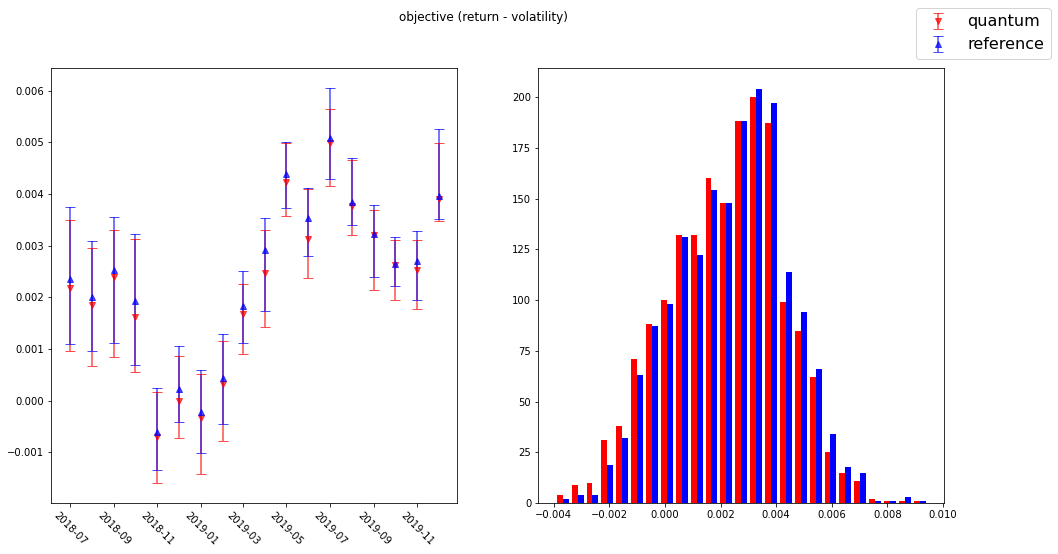

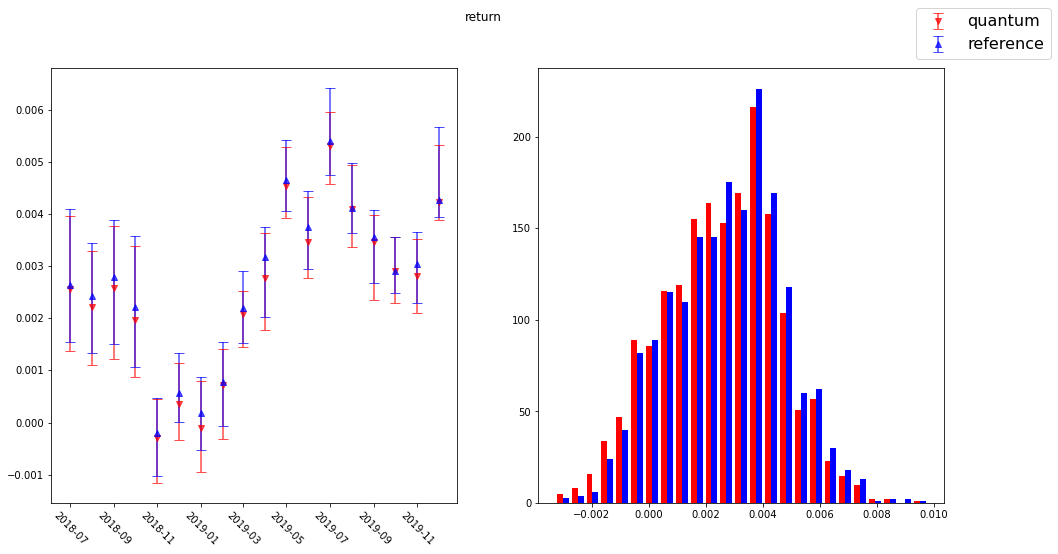

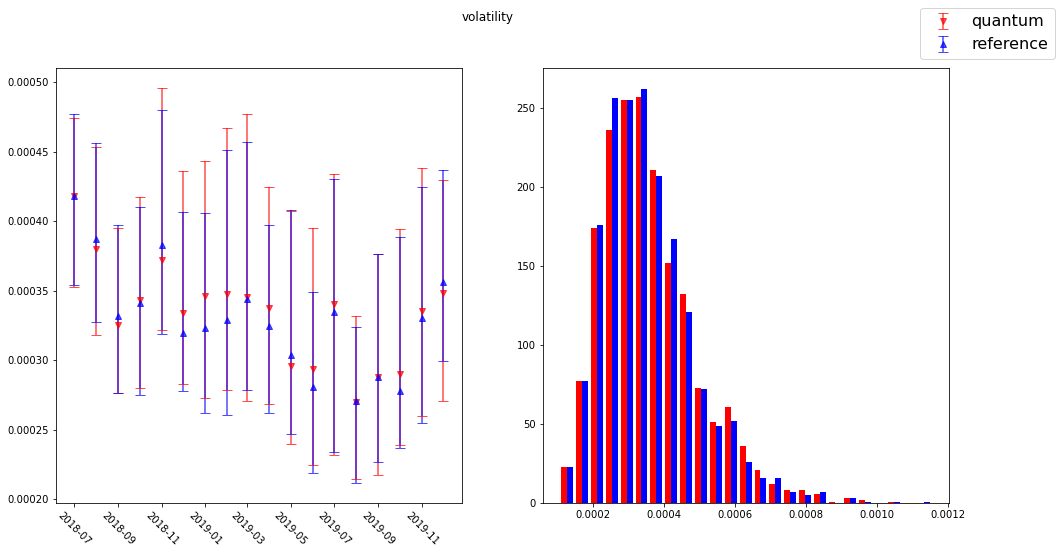

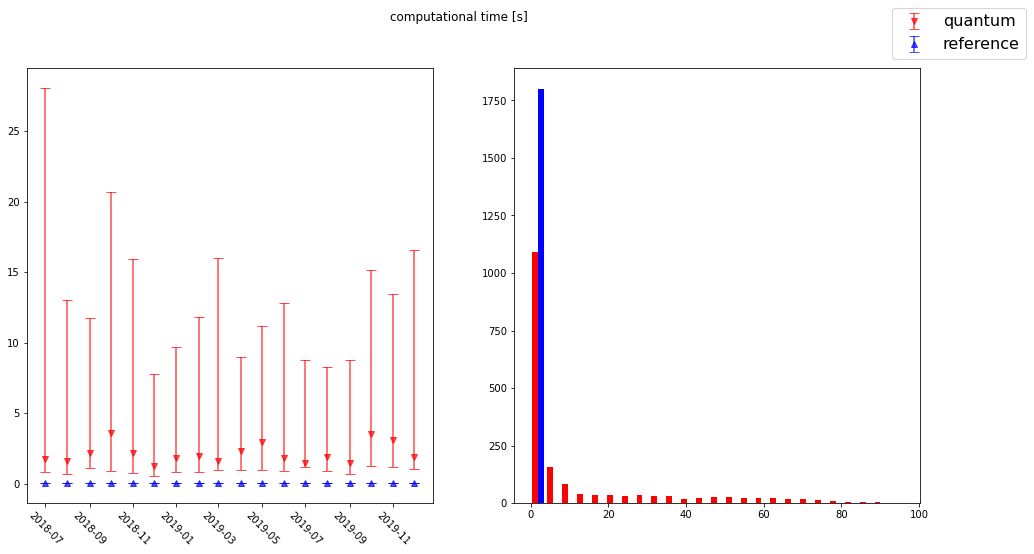

In [95]:
#creates a subplot to display results over a given metric
labels_dict = {'vqe': 'quantum', 'classic': 'reference'}
titles_dict = {'objective_function_value': 'objective (return - volatility)', 'computational_time': 'computational time [s]'}

for metric in metrics: 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
    # scatter plot comparing the different solvers
    for i,solver in enumerate(solvers):
        means = np.array([stats_results[solver][date][metric]['50%'] for date in optim_dates])
        perc25s = np.array([stats_results[solver][date][metric]['25%'] for date in optim_dates])
        perc75s = np.array([stats_results[solver][date][metric]['75%'] for date in optim_dates])
        
        y = means
        err_low = means-perc25s
        err_high = perc75s-means
        error = [err_low, err_high]
        ax1.errorbar(x=optim_dates, y=y, yerr=error, c=palette[solvers.index(solver)%len(palette)], 
                     fmt=markers[solvers.index(solver)%len(markers)], capsize=5, alpha=0.7, label=labels_dict.get(solver,solver))
    #ax1.set_yscale('log')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=-45)
    
    # histogram comparing the different solvers
    ys = [flat_results[s][metric] for s in solvers]
    colors = [palette[solvers.index(s)] for s in solvers]
    ax2.hist(ys, bins=25, color=colors)
    
    fig.suptitle(titles_dict.get(metric, metric))
    fig.legend(prop={'size': 16})